In [ ]:
# Angular variance resultant for generated posts
from pathlib import Path
import json
from typing import List
import math
import torch
from transformers import AutoTokenizer, AutoModel

# Resolve paths relative to this notebook's directory
notebooks_dir = Path.cwd()
backend_dir = notebooks_dir.parent
base = backend_dir / 'data' / 'generated' / 'experiment_ablation' / 'google' / 'gemma-3-27b-it' / 'personal'

summary_path = base / 'summary.json'
soft_candidates = ['soft prompt.json', 'softprompt.json', 'soft_prompt.json']
soft_path = None
for name in soft_candidates:
    candidate = base / name
    if candidate.exists():
        soft_path = candidate
        break

print('Summary path:', summary_path)
print('Soft prompt path:', soft_path)

assert summary_path.exists(), f"Missing file: {summary_path}"
assert soft_path and soft_path.exists(), "Missing soft prompt file (tried: 'soft prompt.json', 'softprompt.json', 'soft_prompt.json')"


def load_posts(path: Path) -> List[dict]:
    with path.open('r', encoding='utf-8') as f:
        data = json.load(f)
    if not isinstance(data, list):
        return []
    return [p for p in data if isinstance(p, dict)]


def extract_texts(posts: List[dict]) -> List[str]:
    texts: List[str] = []
    for p in posts:  # align with UI cap
        title = (p.get('title') or '').strip()
        body = (p.get('self_text') or '').strip()
        if title and body:
            texts.append(f"{title}\n\n{body}")
        else:
            texts.append(title or body)
    return [t for t in texts if t]


@torch.inference_mode()
def embed_texts(texts: List[str], model_name: str = 'sentence-transformers/all-MiniLM-L6-v2', batch_size: int = 32) -> torch.Tensor:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def mean_pool(last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
        summed = torch.sum(last_hidden_state * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-6)
        return summed / counts

    all_embs: List[torch.Tensor] = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}
        out = model(**enc)
        pooled = mean_pool(out.last_hidden_state, enc['attention_mask'])
        all_embs.append(pooled.cpu())
    embs = torch.cat(all_embs, dim=0)
    # L2 normalize (unit vectors)
    embs = torch.nn.functional.normalize(embs, p=2, dim=1)
    return embs


def angular_resultant_and_variance(unit_vectors: torch.Tensor) -> tuple[float, float]:
    # unit_vectors: [N, D], L2-normalized rows
    mean_vec = unit_vectors.mean(dim=0)
    R = float(torch.linalg.vector_norm(mean_vec))  # mean resultant length in [0,1]
    V = 1.0 - R  # angular variance resultant
    return R, V


# Load
summary_posts = load_posts(summary_path)
soft_posts = load_posts(soft_path)

summary_texts = extract_texts(summary_posts)
soft_texts = extract_texts(soft_posts)

print(f"Summary posts used: {len(summary_texts)}")
print(f"Soft prompt posts used: {len(soft_texts)}")

# Embed
summary_embs = embed_texts(summary_texts)
soft_embs = embed_texts(soft_texts)
all_embs = torch.cat([summary_embs, soft_embs], dim=0) if len(soft_embs) else summary_embs

# Compute metrics
R_sum, V_sum = angular_resultant_and_variance(summary_embs)
R_soft, V_soft = angular_resultant_and_variance(soft_embs)
R_all, V_all = angular_resultant_and_variance(all_embs)

print({
    'summary': {'R': round(R_sum, 6), 'angular_variance_resultant': round(V_sum, 6)},
    'soft_prompt': {'R': round(R_soft, 6), 'angular_variance_resultant': round(V_soft, 6)},
    'combined': {'R': round(R_all, 6), 'angular_variance_resultant': round(V_all, 6)},
})


Summary path: /Users/einar/Developer/Projects/Web/slop/backend/data/generated/experiment_ablation/google/gemma-3-27b-it/personal/summary.json
Soft prompt path: /Users/einar/Developer/Projects/Web/slop/backend/data/generated/experiment_ablation/google/gemma-3-27b-it/personal/soft prompt.json
Summary posts used: 50
Soft prompt posts used: 50
{'summary': {'R': 0.778335, 'angular_variance_resultant': 0.221665}, 'soft_prompt': {'R': 0.434592, 'angular_variance_resultant': 0.565408}, 'combined': {'R': 0.527274, 'angular_variance_resultant': 0.472726}}


In [ ]:
# test

from openai import OpenAI
import os, dotenv

dotenv.load_dotenv()

client = OpenAI()


In [9]:
response = client.embeddings.create(
    input="title: Is there a way/mod that would dissable military clothing ?\n self_text: I am looking for a way/mod that would dissable military clothing a for rp so it would feel more authentic.\n subreddit: projectzomboid<end_of_turn>",
    model="text-embedding-3-large"
)

embedding1 = response.data[0].embedding

response = client.embeddings.create(
    input="Is anyone else experiencing extreme lag spikes in Warzone? self_text: Ever since the latest patch, I've been getting massive lag spikes every few minutes, even though my ping stays relatively stable. It's making the game nearly unplayable. I've tried restarting my router, verifying game files, and lowering my graphic settings, but nothing seems to fix it. Has anyone else encountered this issue, and if so, have you found a solution?\n subreddit: Warzone<end_of_turn>",
    model="text-embedding-3-large"
)

embedding2 = response.data[0].embedding

response = client.embeddings.create(
    input="title: Is it normal for my cat to knead my hair?\n self_text: My cat loves to climb on my lap and knead, which is cute, but lately she’s been kneading *my hair* instead of a blanket or my clothes. It doesn’t hurt, but it’s…weird. Is this a common behavior? Should I discourage it?\n subreddit: cats<end_of_turn>",
    model="text-embedding-3-large"
)

embedding3 = response.data[0].embedding

response = client.embeddings.create(
    input="title: Dog keeps stealing socks\n self_text: My golden retriever loves to steal socks, and then hides them all over the house. I’ve tried redirecting with toys, but he’s obsessed with socks. Any advice on how to stop this behavior?\n subreddit: dogs<end_of_turn>",
    model="text-embedding-3-large"
)

embedding4 = response.data[0].embedding


In [5]:
response = client.embeddings.create(
    input="title: My partner keeps forgetting to reimburse me for shared expenses\n self_text: Okay, so we’ve been together 2 years and live together. We don’t have joint finances – mostly because we both had messy situations before meeting and are hesitant to fully merge everything. But we *do* split bills pretty evenly. The problem is, I often end up fronting costs for things like groceries, household supplies, or even date nights, with the understanding he’ll Venmo me his half. And…he just doesn't. Not consistently, anyway. He’ll say he “forgot,” or that money is tight (even though he just bought a new video game). I've brought it up multiple times, trying to be calm and rational (\"Hey, could you send over $40 for groceries?\"), but it always feels like pulling teeth. Last week I covered almost all of our gas for a road trip and still haven’t seen a dime. It’s not huge amounts individually, but it adds up! And honestly, it feels disrespectful, like my time and effort aren't valued. Is it ridiculous to feel this way? Am I supposed to just constantly remind him? I'm starting to resent having to ask at all. AITA for expecting him to follow through when we agree on splitting costs? Any advice on how to handle this without blowing up at him?\n subreddit: relationships<end_of_turn>",
    model="text-embedding-3-large"
)

embedding5 = response.data[0].embedding
response  = client.embeddings.create(
    input=" title: My (32F) partner (35M) keeps \"forgetting\" to reimburse me for shared expenses - am I being unreasonable to be frustrated?\n self_text: Okay, so we’ve been together 3 years, living together for 1.5. We don’t have joint finances – both very independent people which was great at first. But lately, it feels like I’m constantly fronting costs for things *we* both benefit from (groceries, utilities, date nights, even pet supplies). He always says he’ll Venmo me, genuinely apologizes for forgetting, then…doesn’t. Or remembers weeks later after I’ve brought it up again. It’s not huge amounts each time ($20-$50 usually), but it adds up! And honestly, it feels disrespectful now. Like my time & money aren't valued. I’ve tried gently reminding him, then more directly asking, and even suggesting we alternate who pays for what each week. Nothing sticks. AITA for getting increasingly annoyed by this? Is there a way to address this without starting a massive fight? I just want a fair split and some acknowledgement that I’m contributing equally.\n subreddit: relationships<end_of_turn>",
    model="text-embedding-3-large"
)

embedding6 = response.data[0].embedding



In [ ]:
import numpy as np

# calculate cosine similarity between embedding1 and embedding2
# cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
# print(cosine_similarity)

# # calculate cosine similarity between embedding1 and embedding3
# cosine_similarity = np.dot(embedding1, embedding3) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding3))
# print(cosine_similarity)

# # calculate cosine similarity between embedding3 and embedding4
# cosine_similarity = np.dot(embedding3, embedding4) / (np.linalg.norm(embedding3) * np.linalg.norm(embedding4))
# print(cosine_similarity)

# calculate cosine similarity between embedding5 and embedding6
cosine_similarity = np.dot(embedding5, embedding6) / (np.linalg.norm(embedding5) * np.linalg.norm(embedding6))
print(cosine_similarity)






0.9295794081681001


In [ ]:
# Calculate variance across all embeddings
embeddings = [embedding1, embedding2, embedding3, embedding4, embedding5, embedding6]

def angular_variance_resultant(X):
    """
    1 - resultant length for L2-normalized embeddings.
    """
    X = np.asarray(X, dtype=float)
    Y = X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)
    R = np.linalg.norm(Y.mean(axis=0))
    return 1.0 - R

variance = angular_variance_resultant(embeddings)
print(variance)


0.34554694215198034


In [ ]:
%pip install umap-learn hdbscan matplotlib

/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


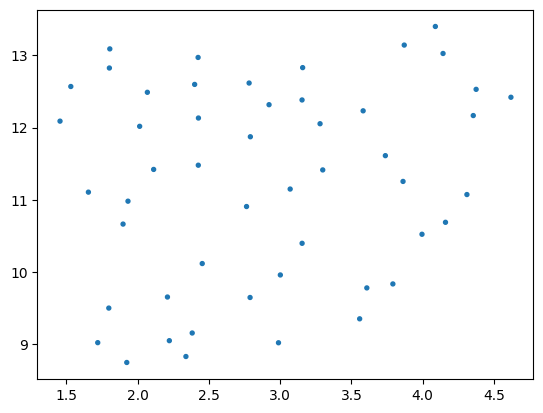

0


/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/einar/miniconda3/envs/slop/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


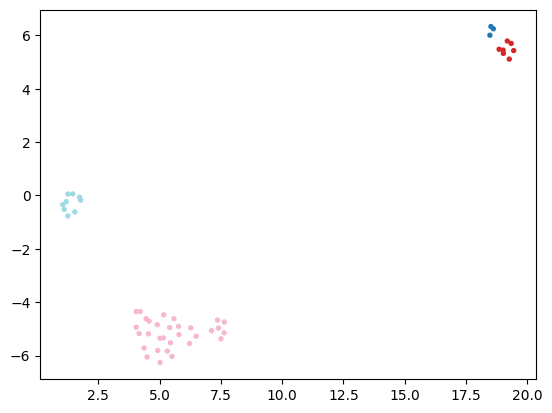

3


In [25]:
import numpy as np
import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt

def plot_embeddings(embeddings):        
    # X = (n, d) embeddings, already normalized
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_2d = reducer.fit_transform(embeddings)

    # Cluster in high-d space
    clusterer = hdbscan.HDBSCAN()
    labels = clusterer.fit_predict(embeddings)

    # Plot
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab20", s=8)
    # plt.colorbar()
    plt.show()
    
    # Return number of clusters (excluding noise points labeled as -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters
    
print(plot_embeddings(soft_embs))   
print(plot_embeddings(summary_embs))


## Load judgements

In [ ]:
def load_posts(path: Path) -> List[dict]:
    with path.open('r', encoding='utf-8') as f:
        data = json.load(f)
    if not isinstance(data, list):
        return []
    return [p for p in data if isinstance(p, dict)]


def extract_texts(posts: List[dict]) -> List[str]:
    texts: List[str] = []
    for p in posts:  # align with UI cap
        title = (p.get('title') or '').strip()
        body = (p.get('self_text') or '').strip()
        if title and body:
            texts.append(f"{title}\n\n{body}")
        else:
            texts.append(title or body)
    return [t for t in texts if t]

In [ ]:
# clean up json to add model, experiment, dataset fields based on file path

## Calculate variances

## Clustering